In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D

In [2]:
data_dir = 'datasets/id002_cj'
results_dir = 'tmp'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
slp_ds = slp[0:-1:10,:]
snsr_pwr = np.sum(slp_ds**2, axis=0)

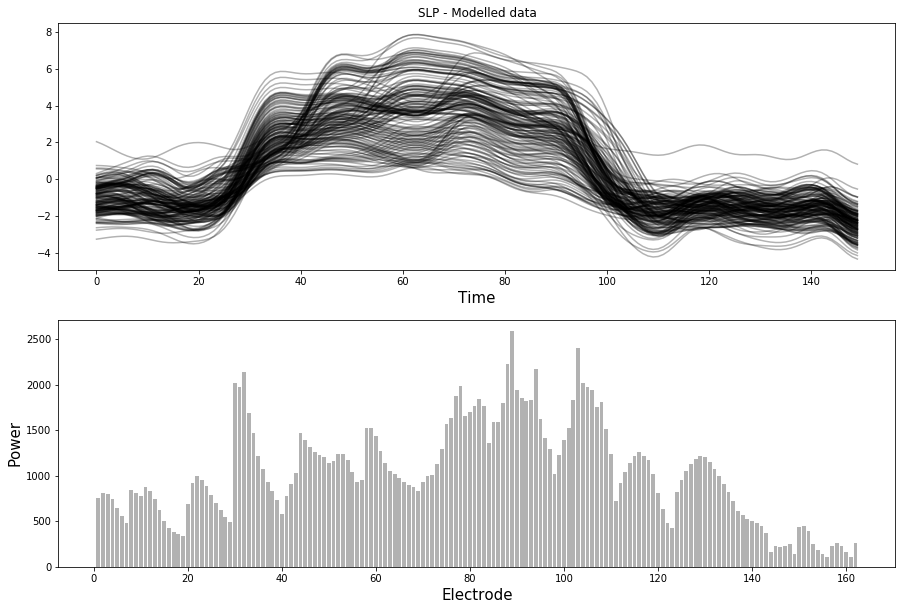

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [5]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]
I1 = 3.1
# tau0=30
# time_step=0.1
dtt = 0.1
alpha = 0.1

stan_fname = 'vep-snsrfit-ode'
# lib.utils.stan.compile('/home/anirudh/Softwares/cmdstan-2.18.0', 'vep-snsrfit-ode')

x0_star = np.zeros(nn)
x_init_star = np.zeros(nn)
z_init_star = np.zeros(nn)
amplitude_star = 0.0
offset = 0.0
K_star = 0.0
time_step_star = 0.0
tau0_star = 0.0

param_init = {'x0_star':x0_star, 'x_init_star':x_init_star, 'z_init_star':z_init_star,
              'amplitude_star':amplitude_star, 'offset':offset, 'K_star':K_star,
              'time_step_star':time_step_star, 'tau0_star':tau0_star}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

epsilon_snsr_pwr = 5.0
for epsilon_slp in np.array([0.1]):
    fname_suffix = f'epsslp{epsilon_slp:0.5f}_epssnsrpwr_{epsilon_snsr_pwr:0.5f}'
    data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'dtt':dtt, 'SC':SC, 'gain': gain_mat,
            'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr,
            'slp':slp_ds, 'snsr_pwr':snsr_pwr, 'alpha':alpha}
    input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
    os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
    lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [6]:
%%bash -s "$stan_fname"
stancompile.sh $1

/home/anirudh/Academia/projects/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode.stan --o=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode.hpp
Model name=vep_snsrfit_ode_model
Input file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode.stan
Output file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode -include /ho

DIAGNOSTIC(S) FROM PARSER:



In [7]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
for i in {1..1};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=200 num_warmup=200 \
save_warmup=1 adapt delta=0.8 algorithm=hmc engine=nuts max_depth=10 metric=dense_e \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987324514*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_cntr_${FNAME_SUFFIX}_chain${i}.log &
done

In [8]:
# import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

# csv_fname = 'results/exp10/exp10.4/samples_epsinfer_chain1.csv'
# nwarmup = 200
# nsampling = 100
# ignore_warmup = True



variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
                         'divergent__', 'energy__','x0',  'x', 'z', 'mu_slp', 'mu_snsr_pwr',\
                         'amplitude', 'offset', 'time_step', 'tau0', 'K', 'x_init', 'z_init',\
                         'nsteps']
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in [1]],
                                      variables_of_interest=variables_of_interest) #nwarmup=200, nsampling=60)
# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

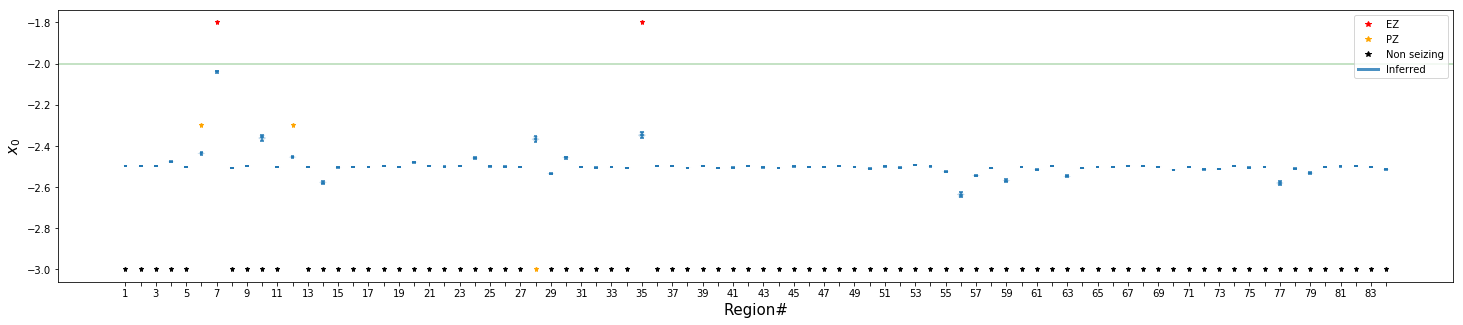

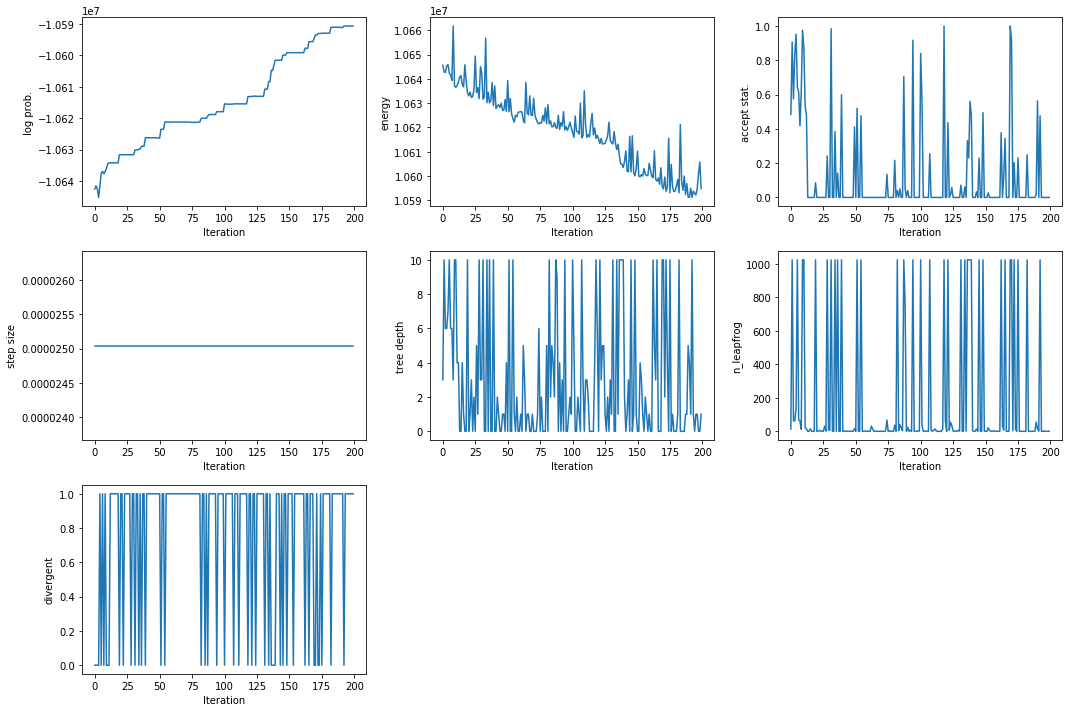

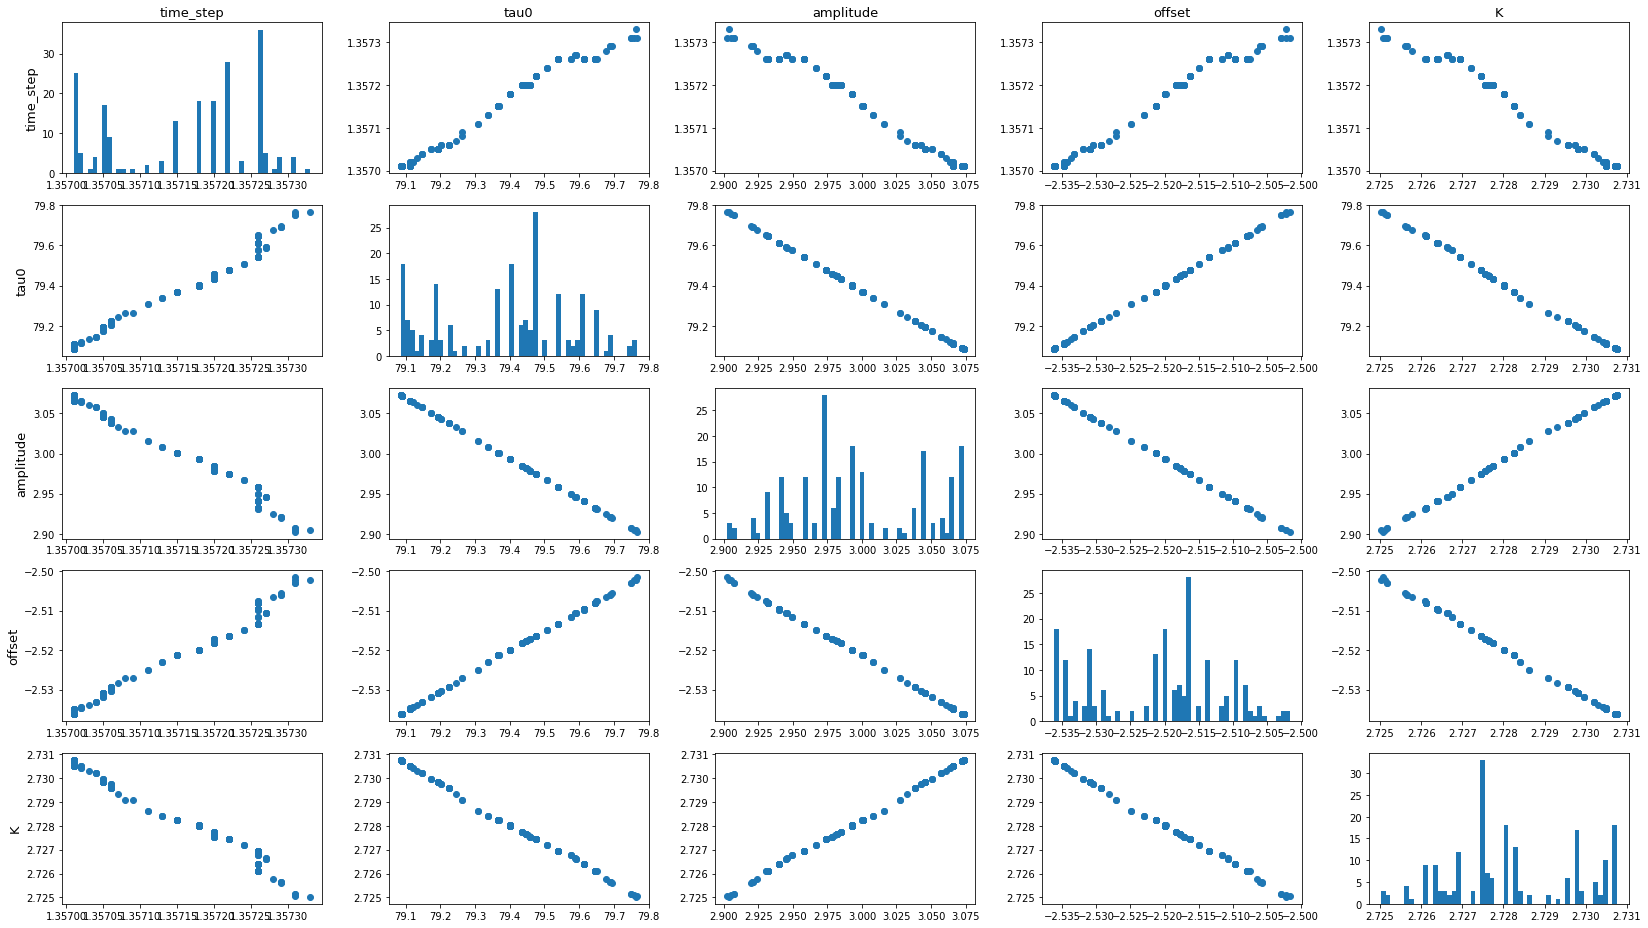

In [15]:
import importlib
importlib.reload(lib.plots.stan)

syn_data = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin_syn(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')

lib.plots.stan.nuts_diagnostics(pstr_samples_1, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')

plt.figure(figsize=(23,13))
params = ['time_step', 'tau0', 'amplitude', 'offset', 'K']
nParams = len(params)
for i in range(nParams):
    for j in range(nParams):
        plt.subplot(nParams, nParams, i * nParams + (j + 1))
        if(i == j):
            plt.hist(pstr_samples_1[params[i]].flatten(), bins=50)
        else:
            xvals = np.mean(pstr_samples_1[params[j]], axis=1) if len(pstr_samples_1[params[j]].shape)>1 else pstr_samples_1[params[j]]
            yvals = np.mean(pstr_samples_1[params[i]], axis=1) if len(pstr_samples_1[params[i]].shape)>1 else pstr_samples_1[params[i]]
            plt.plot(xvals, yvals, 'o')
        if(i == 0):
            plt.title(params[j], fontsize=13)
        if(j == 0):
            plt.ylabel(params[i], fontsize=13, rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')

# # Mean and 2*std of source activity(x) estimated from posterior samples
# plt.figure(figsize=(15,20))
# x_mean = np.mean(pstr_samples_1['x'], axis = 0)
# x_std = np.std(pstr_samples_1['x'], axis = 0)
# nt = x_mean.shape[0]
# nn = x_mean.shape[1]
# for i in range(nn):
#     plt.plot(x_mean[:,i]+4*i)
#     plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
# plt.title('source activity(x)',fontsize=15);
# plt.xlabel('time',fontsize=15);
# plt.ylabel('Region#',fontsize=15);
# plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);

In [14]:
print(np.argsort(pstr_samples_1['x0'].mean(axis=0)))
# pstr_samples_1['x0'].shape
print(ez,pz)
print(pstr_samples_1['time_step'].mean(axis=0))

[55 76 13 58 62 56 28 78 54 69 60 83 71 72 77 49 57 63 39 33 43 51 37 40
 31  7 74 14 64 42  4 26 46 65 32 18 12 79 82 70 10 68 75 48 30 59 45 15
 16 25 21 80 61 53 67 24 50  1 44 35 17  2 36 47 81 73 22 41  8  0 66 20
 38 52 19  3 23 29 11  5 27  9 34  6]
[ 6 34] [ 5 11 27]
1.3571608499999999


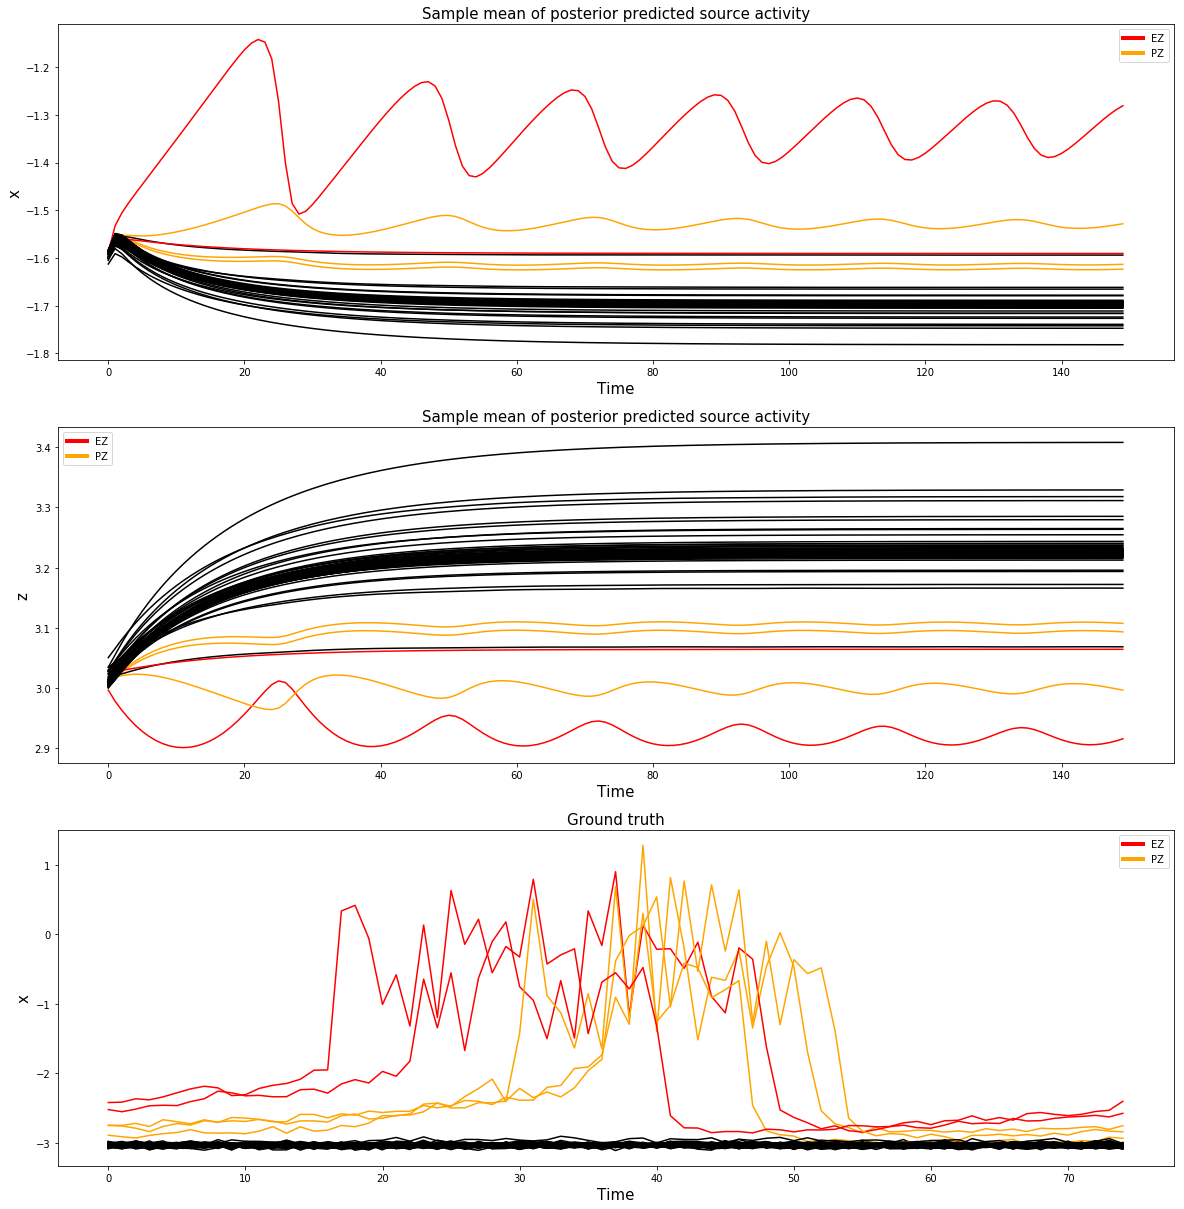

In [11]:
x_syn = syn_data['src_sig'][2500:4000,0,:,0] + syn_data['src_sig'][2500:4000,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

x_pp_mean = np.mean(pstr_samples_1['x'], axis=0)
z_pp_mean = np.mean(pstr_samples_1['z'], axis=0)


plt.figure(figsize=(20,21))
plt.subplot(311)
legend_elements = [Line2D([0], [0], color='red', linewidth=4, label='EZ'),
                   Line2D([0], [0], color='orange', linewidth=4, label='PZ')]
for i in range(nn):
    if(i in ez):
        plt.plot(x_pp_mean[:,i], color='red');
    elif(i in pz):
        plt.plot(x_pp_mean[:,i], color='orange');
    else:
        plt.plot(x_pp_mean[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Sample mean of posterior predicted source activity', fontsize=15)
plt.legend(handles=legend_elements)

plt.subplot(312)
for i in range(nn):
    if(i in ez):
        plt.plot(z_pp_mean[:,i], color='red');
    elif(i in pz):
        plt.plot(z_pp_mean[:,i], color='orange');
    else:
        plt.plot(z_pp_mean[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Sample mean of posterior predicted source activity', fontsize=15)
plt.legend(handles=legend_elements)

plt.subplot(313)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[0:-1:20,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[0:-1:20,i], color='orange');
    else:
        plt.plot(x_syn[0:-1:20,i], color='black');
plt.title('Ground truth', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/posterior_simulation_src_{fname_suffix}.png')

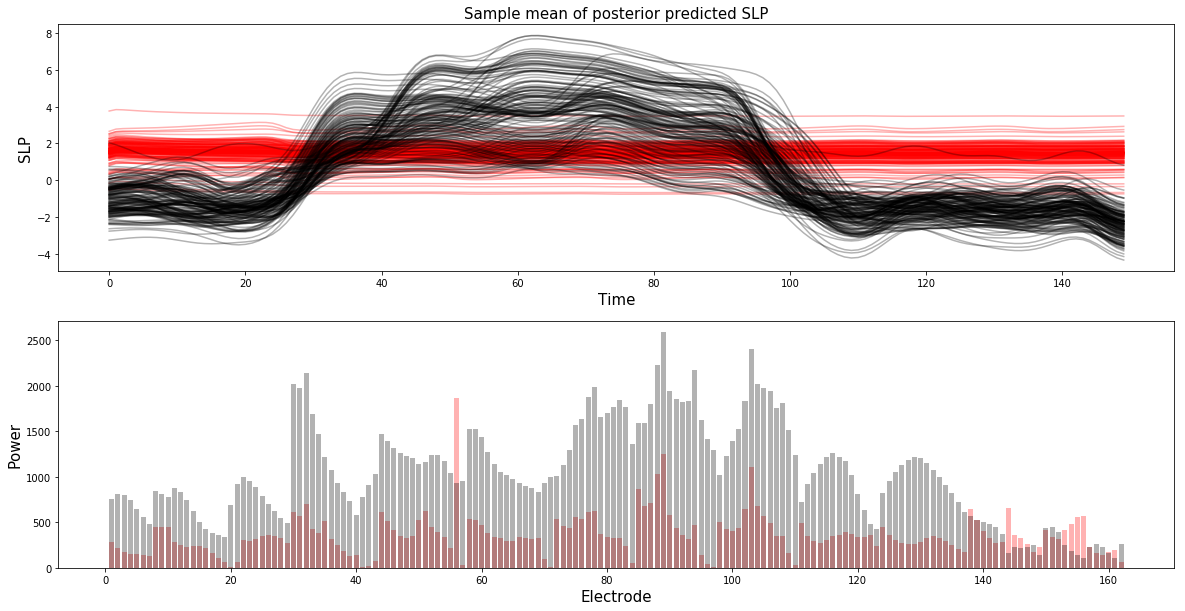

In [12]:
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
slp = pstr_samples_1['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples_1['mu_snsr_pwr'].mean(axis=0)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(slp, color='red', alpha=0.3);
plt.plot(fit_data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Sample mean of posterior predicted SLP', fontsize=15)

plt.subplot(212)
plt.bar(np.arange(1,ns+1), snsr_pwr, color='red', alpha=0.3);
plt.bar(np.arange(1,ns+1), fit_data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')